# DM-41679 Generate LsstComCam simulation data 

* two circumpolar fields separated by at least 3.5 degrees (visible year-round from Cerro Pachon)
* previously considered target had ra=20:28:18.74   deg=-87:28:19.9 https://jira.lsstcorp.org/browse/DM-35005 
* two defocal offsets: +/- 1.5 mm, and an in-focus exposure
* simulation sourced from opSim, using GAIA stellar catalog, selecting max_flux of 1e9
                    
                    
# Setup

Last verified to run:  2023-12-13

* ts_wep : 8.0.4
* imsim : 2.0  , `comcam` branch 
* galsim : 2.5.1 
* lsst_distrib : w2023_49  ext (cvms)


In particular, the following setup was employed:


    source /cvmfs/sw.lsst.eu/linux-x86_64/lsst_distrib/w_2023_49/loadLSST-ext.bash 
    setup lsst_distrib -t w_latest

    export IMSIM_HOME=/sdf/home/s/scichris/link_to_scichris/WORK/imsim_home
    export RUBIN_SIM_DATA_DIR=$IMSIM_HOME/rubin_sim_data
    export SIMS_SED_LIBRARY_DIR=$IMSIM_HOME/rubin_sim_data/sims_sed_library
    setup -k -r $IMSIM_HOME/imSim
    setup -k -r $IMSIM_HOME/skyCatalogs

    export PATH_TO_TS_WEP=/sdf/data/rubin/user/scichris/WORK/aos_packages/ts_wep/
    eups declare -r $PATH_TO_TS_WEP -t $USER --nolocks
    setup ts_wep -t $USER  -t current




# Imports 

In [7]:
from lsst.afw.cameraGeom import PIXELS, FIELD_ANGLE, FOCAL_PLANE
from lsst.geom import Point2D
from astropy.table import Table
import lsst.obs.lsst as obs_lsst
import numpy as np
import sqlite3
import numpy as np
import pandas as pd

from astropy import units as u
from astropy.coordinates import angular_separation
from lsst.ts.wep.utils import  runProgram
import os
from lsst.daf import butler as dafButler
from astropy.coordinates import SkyCoord
from astropy import units as u

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

INFO:numexpr.utils:Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


# Creating imsim  config yaml

Some configs that are specific to generating defocal images:

We generate the focus sweep by changing


 
     input.telescope.focusZ: 0.0015   # telescope offset is in meters

     output.header:
        focusZ: 1.5   # header is in mm
        seqnum: 942
        
We ensure that FFT is not used (which generates in-focus image for bright sources) by setting 


     stamp.fft_sb_thresh: 0 
    
We limit the max brightness of simulated sources

     input.sky_catalog.max_flux: 1e9

We enlarge the imsim stamp size to avoid cutting off donut edges 
 
    image.stamp_size: 300
    stamp.size: 300
    

The OPD is generated at CCD centers: 



In [1]:
camera =  obs_lsst.LsstComCam().getCamera()

# only for instName = "lsst"   
fieldX, fieldY = list(), list()
fieldXrad, fieldYrad = list(), list()
detName = list()

detectors = list(camera.getNameMap().keys())


xps, yps = [],[]
for name in detectors:
    detector = camera.get(name) 
    # xp, yp = detector.getCenter(FOCAL_PLANE) # in mm 
    xp_rad, yp_rad = detector.getCenter(FIELD_ANGLE)  # in radians 
    xp_deg =  np.rad2deg(xp_rad)
    yp_deg = np.rad2deg(yp_rad)
    print(name, detector.getId(), xp_deg, yp_deg)
    xps.append(xp_deg)
    yps.append(yp_deg)
    
    
# print in a format expected by imsim 

i=0
for name in detectors:
    print("    - thx:", xps[i], "deg")
    print("      thy:", yps[i], "deg ")#"# ", name)
    i+=1 

INFO:numexpr.utils:Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


R22_S21 7 -5.555555555556424e-05 0.2346666666666667
R22_S20 6 -0.23477777777777778 0.2346666666666667
R22_S12 5 0.23466666666666663 -5.55555555555445e-05
R22_S11 4 -5.555555555556424e-05 -5.55555555555445e-05
R22_S10 3 -0.23477777777777778 -5.55555555555445e-05
R22_S22 8 0.23466666666666663 0.2346666666666667
R22_S02 2 0.23466666666666663 -0.23477777777777772
R22_S01 1 -5.555555555556424e-05 -0.2347777777777777
R22_S00 0 -0.23477777777777784 -0.23477777777777772
    - thx: -5.555555555556424e-05 deg
      thy: 0.2346666666666667 deg 
    - thx: -0.23477777777777778 deg
      thy: 0.2346666666666667 deg 
    - thx: 0.23466666666666663 deg
      thy: -5.55555555555445e-05 deg 
    - thx: -5.555555555556424e-05 deg
      thy: -5.55555555555445e-05 deg 
    - thx: -0.23477777777777778 deg
      thy: -5.55555555555445e-05 deg 
    - thx: 0.23466666666666663 deg
      thy: 0.2346666666666667 deg 
    - thx: 0.23466666666666663 deg
      thy: -0.23477777777777772 deg 
    - thx: -5.5555555555

The `imsim-config.yaml` contains:

    modules: [imsim]
    template: imsim-config-skycat

    # Use skyCatalogs for obtaining the objects to render.
    input.sky_catalog:
      file_name: /sdf/data/rubin/user/jchiang/imSim/skyCatalogs_v2/skyCatalog.yaml
      approx_nobjects: 1000
      band: { type: OpsimData, field: band }
      mjd: { type: OpsimData, field: mjd }
      obj_types: [gaia_star]
      max_flux: 1e7 

    input.opsim_data.file_name: /sdf/data/rubin/user/jchiang/imSim/rubin_sim_data/opsim_cadences/baseline_v3.2_10yrs.db
    input.opsim_data.visit: 740000

    input.atm_psf.screen_size: 819.2
    input.atm_psf.save_file:
      type: FormattedStr
      format: atm_psf_files/atm_psf_%08d-%1d-%s.pkl
      items:
          - { type: OpsimData, field: observationId }
          - { type: OpsimData, field: snap }
          - { type: OpsimData, field: band }

    # offset the piston by 1.5 mm 
    input.telescope.focusZ: 0   # telescope offset is in meters

    # disable checkpointing
    input.checkpoint: ""
    image.random_seed: '@input.opsim_data.visit'

    # enlarge the stamp size 
    # to avoid cutting off donut edges 
    image.stamp_size: 300
    stamp.size: 300

    # disable FFT by changing this variable 
    # that sets the limit above which FFT would be triggered...
    stamp.fft_sb_thresh: 0

    # simulate no objects for OPD-only
    #image.nobjects: 0

    output.nproc: 9
    output.det_num.first: 0 
    output.nfiles: 9

    # make no amp images
    #output.readout: ""

    output.header:
        focusZ: 0.0   # header is in mm 
        seqnum: 941

    output.camera: LsstComCam
    output.dir:
        type: FormattedStr
        format : output-max-flux-stamp/%08d
        items:
            - "@input.opsim_data.visit"

    # create OPD at all R22 locations 
    output.opd:
        file_name:
            type: FormattedStr
            format: opd_%s.fits.fz
            items:
                - "@input.telescope.focusZ"
        rotTelPos:  "@input.telescope.rotTelPos"
        fields:
        - thx: -5.555555555556424e-05 deg
          thy: 0.2346666666666667 deg 
        - thx: -0.23477777777777778 deg
          thy: 0.2346666666666667 deg 
        - thx: 0.23466666666666663 deg
          thy: -5.55555555555445e-05 deg 
        - thx: -5.555555555556424e-05 deg
          thy: -5.55555555555445e-05 deg 
        - thx: -0.23477777777777778 deg
          thy: -5.55555555555445e-05 deg 
        - thx: 0.23466666666666663 deg
          thy: 0.2346666666666667 deg 
        - thx: 0.23466666666666663 deg
          thy: -0.23477777777777772 deg 
        - thx: -5.555555555556424e-05 deg
          thy: -0.2347777777777777 deg 
        - thx: -0.23477777777777784 deg
          thy: -0.23477777777777772 deg 

    # apply specific formatting to the amp images 
    output.readout.file_name:
        type: FormattedStr
        format : amp_%08d-%1d-%s-%s-det%03d-%s.fits.fz
        items:
            - "@input.opsim_data.visit"  # eg. 00740000
            - 0   # snap 
            - $band  # eg. g
            - $det_name  # eg. R22_S10 
            - "@output.det_num"  # eg. 91--> 091  
            - "@input.telescope.focusZ" #  eg. 0.0015 

    output.timeout: 1e5
    output.truth.dir: '@output.dir'
    output.truth.file_name.format: centroid_%08d-%1d-%s-%s-det%03d.txt.gz

## Choose two appropriate opsim visits

In [2]:
# We could find visits that are close to a given ra/dec, 
#like in https://jira.lsstcorp.org/browse/DM-35005

#  ra            dec 
# 20:28:18.74 -87:28:19.9 (original target, with PA=0º)
                             
c0 = SkyCoord('20:28:18.74 -87:28:19.9', unit=(u.hourangle, u.deg))


columns = '*'

opsim_db_file = '/sdf/data/rubin/user/jchiang/imSim/rubin_sim_data/opsim_cadences/baseline_v3.2_10yrs.db'

ra0 = c0.ra.deg
dec0 =  c0.dec.deg
delta = 1 # deg 

query = (f"select {columns} from observations "
         f"where ({ra0 - delta} < fieldRA) "
         f"and (fieldRA < {ra0 + delta}) "
         f"and ({dec0 - delta} < fieldDec) "
         f"and (fieldDec < {dec0 + delta})")

with sqlite3.connect(opsim_db_file) as con:
    df0 = pd.read_sql(query, con)
    

In [3]:
df0

,observationId,fieldRA,fieldDec,observationStartMJD,flush_by_mjd,visitExposureTime,filter,rotSkyPos,rotSkyPos_desired,numExposures,airmass,seeingFwhm500,seeingFwhmEff,seeingFwhmGeom,skyBrightness,night,slewTime,visitTime,slewDistance,fiveSigmaDepth,altitude,azimuth,paraAngle,cloud,moonAlt,sunAlt,note,target,fieldId,proposalId,block_id,observationStartLST,rotTelPos,rotTelPos_backup,moonAz,sunAz,sunRA,sunDec,moonRA,moonDec,moonDistance,solarElong,moonPhase,cummTelAz,scripted_id
0,68609,306.661504,-86.924706,60907.222885,60907.251796,30.0,u,285.230776,285.230776,1,1.843517,0.493944,1.140989,0.989893,22.577148,111,9.405863,31.0,3.207455,23.311388,32.849998,181.917147,32.595625,0.000,-50.097017,-70.460814,"pair_33, ug, a",,-1,31,1,338.293047,-42.173599,-47.621862,83.642600,155.468972,149.311262,12.475485,112.418530,26.631596,119.609695,105.310656,20.754213,-43.881511,0
1,68659,306.661504,-86.924706,60907.246674,60907.251796,30.0,g,285.230776,285.230776,2,1.857446,0.589094,1.223033,1.057333,22.030924,111,9.405863,34.0,3.207455,24.179729,32.572990,182.354017,41.406847,0.000,-43.117107,-66.027409,"pair_33, ug, b",,-1,81,1,346.880500,-33.362377,-47.621862,80.618694,134.791048,149.333306,12.467650,112.861448,26.609109,119.593130,105.302361,20.551207,-48.434874,0
2,726966,306.608899,-87.397563,61984.000545,61984.024797,30.0,z,10.539573,0.000000,2,1.929010,0.981618,1.612255,1.377274,18.626410,1188,27.973744,34.0,3.111463,22.050804,31.225027,177.195329,291.414228,0.125,72.539933,-24.025511,"blob_long, iz, a",,-1,38,1,239.573633,-58.046199,0.000000,80.009662,277.485396,131.309193,18.035812,258.319761,-25.821576,62.463349,110.629359,72.526945,-175.471844,0
3,1429362,307.898688,-87.230149,63240.216662,63240.255151,30.0,g,190.864470,190.864470,2,2.162996,0.795031,1.681505,1.434197,21.853259,2444,4.898368,34.0,3.153759,23.700319,27.537026,180.668252,167.965745,0.000,-16.022911,-37.328838,"pair_33, gr, a",,-1,10,1,115.561946,-1.169786,-2.979936,123.002069,173.567219,289.531984,-22.221248,237.020538,-18.162864,70.949817,65.152872,27.341871,-205.207769,0
4,1429412,307.898688,-87.230149,63240.242674,63240.255151,30.0,r,190.864470,190.864470,2,2.167267,0.709344,1.449782,1.243721,20.789772,2444,4.889073,34.0,3.153759,23.429074,27.478163,180.161548,177.110812,0.000,-9.297232,-35.672059,"pair_33, gr, b",,-1,60,1,124.951927,7.975282,-2.979936,117.688226,162.924294,289.560375,-22.217719,237.467997,-18.248823,70.843448,65.155961,27.115905,-207.590674,0
5,2032781,306.709935,-87.895073,64323.253059,64323.281498,30.0,z,140.300978,140.300978,2,2.117906,0.662950,1.269820,1.095792,18.531647,3527,19.696814,34.0,2.817896,22.251344,28.174896,180.440611,169.579535,0.000,42.277248,-33.066577,"pair_33, iz, a",,-1,30,1,116.156708,-50.119488,-55.435473,9.176925,157.859535,275.500548,-23.338420,122.733061,17.095080,109.194879,64.865931,85.410819,-136.093553,0
6,2032831,306.709935,-87.895073,64323.278912,64323.281498,30.0,i,140.300978,140.300978,2,2.120317,0.996458,1.789567,1.523024,19.033075,3527,19.696814,34.0,2.817896,22.279260,28.140006,180.054262,178.723656,0.000,42.780929,-29.443312,"pair_33, iz, b",,-1,80,1,125.489417,-40.975366,-55.435473,357.330786,148.796310,275.529204,-23.337413,122.978246,17.036857,109.137269,64.866385,85.291565,-137.101637,0


We see that even with such large allowance for pointing, only a few visits actually have a dark moon (phase < 30%) and good moon separation (>100 deg), so that lunar illumination doesn't cause any additional background...

Let's choose 68659: ra=306.661504,	dec=-86.924706  since it's particularly dark night (only 20% lunar phase, 120 deg away, and the sun is ~60 deg below the horizon.
                                                       
                                               

Now find a field that's about 3.5 degrees away from this visit, also in `g` filter:

In [64]:
ra1 = 306.661504
dec1 = -86.924706
delta = 1 # degrees 
query = (f"select {columns} from observations "
         f"where ({ra1 - delta} > fieldRA) "
         f"and (fieldRA < {ra1 + delta}) "
         f"and ({dec1 - delta} < fieldDec) "
         f"and (fieldDec < {dec1 + delta})"
        f"and filter=='g'")
with sqlite3.connect(opsim_db_file) as con:
    df1 = pd.read_sql(query, con)

In [65]:
df1

,observationId,fieldRA,fieldDec,observationStartMJD,flush_by_mjd,visitExposureTime,filter,rotSkyPos,rotSkyPos_desired,numExposures,airmass,seeingFwhm500,seeingFwhmEff,seeingFwhmGeom,skyBrightness,night,slewTime,visitTime,slewDistance,fiveSigmaDepth,altitude,azimuth,paraAngle,cloud,moonAlt,sunAlt,note,target,fieldId,proposalId,block_id,observationStartLST,rotTelPos,rotTelPos_backup,moonAz,sunAz,sunRA,sunDec,moonRA,moonDec,moonDistance,solarElong,moonPhase,cummTelAz,scripted_id
0,532,155.895607,-86.618383,60796.244317,60796.283307,30.0,g,322.837915,322.837915,2,1.956706,0.708734,1.445876,1.240510,22.020338,0,10.736734,34.0,3.141648,23.972775,30.734653,183.883012,82.653115,0.000,-62.352828,-67.663401,"pair_33, ug, a",,-1,10,1,236.622836,45.491029,43.832968,274.426208,128.945654,38.341237,15.051156,88.055139,28.660545,117.339462,106.593491,26.523582,-164.187612,0
1,2786,188.574828,-87.324281,60798.333227,60798.358433,30.0,g,340.399639,340.399639,2,1.965811,0.463636,1.083924,0.942986,22.025415,2,7.777000,34.0,3.072252,24.285581,30.576998,183.078615,83.640818,0.000,-63.001588,-42.176745,"pair_33, gr, a",,-1,36,1,270.689474,64.040457,57.375667,266.113501,95.932698,40.341686,15.674678,120.283604,25.045975,114.031569,107.944419,41.406101,-47.299237,0
2,4777,217.811747,-86.754360,60800.334142,60800.339757,30.0,g,252.303260,252.303260,2,1.883867,0.660290,1.339457,1.153034,22.023917,4,4.366144,34.0,2.934920,24.072704,32.061074,183.143187,56.787315,0.000,-39.414877,-42.112652,"pair_33, gr, b",,-1,80,1,272.990763,-50.909425,-64.931624,266.862903,95.018223,42.266925,16.254109,146.190332,16.573716,105.526370,109.489766,54.521463,-111.212404,0
3,19181,242.924305,-87.035805,60822.360718,60822.370191,30.0,g,304.314387,304.314387,2,1.906702,0.455166,1.052813,0.917412,22.028344,26,9.625808,34.0,2.761854,24.330942,31.632296,183.053922,62.874547,0.250,-40.948481,-36.014294,"pair_33, ug, b",,-1,70,1,304.268612,7.188934,-5.324639,79.124256,84.396084,64.076616,21.299088,67.570784,26.876551,119.830733,114.262672,3.569062,-179.122005,0
4,19183,188.293544,-86.259509,60822.361967,60822.370191,30.0,g,248.981923,248.981923,2,2.093893,0.455166,1.113664,0.967432,21.990947,26,12.078484,34.0,2.756450,24.215724,28.527426,183.814302,118.248067,0.250,-40.588779,-35.627701,"pair_33, ug, b",,-1,72,1,304.719703,7.229991,-5.324639,78.966084,84.199312,64.077885,21.299297,67.595448,26.882352,118.744360,113.368548,3.577638,-178.361176,0
5,35050,290.548905,-86.198999,60855.986346,60856.015074,30.0,g,117.102615,0.000000,2,1.981604,0.600785,1.289149,1.111681,21.471527,60,6.513770,34.0,2.813601,23.872492,30.307566,175.599024,269.841858,0.125,30.566044,-22.490545,"blob_long, gr, a",,-1,29,1,202.637614,26.944474,0.000000,306.834366,284.571570,98.829425,23.187738,157.716107,11.061858,103.631602,116.907091,31.777602,-186.878656,0
6,90543,296.397837,-86.696314,60934.207488,60934.222297,30.0,g,349.593421,349.593421,2,1.902687,0.571552,1.215091,1.050805,22.011128,138,24.603275,34.0,3.147038,24.169634,31.706794,183.455472,64.625783,0.000,-29.498259,-61.858285,"pair_33, ug, b",,-1,49,1,359.347435,54.219203,45.237636,73.638767,168.844420,173.788514,2.685819,108.820153,27.420088,120.694004,94.462325,37.013813,-121.439853,0
7,108857,4.849587,-86.219915,60966.316522,60966.326845,30.0,g,271.323993,271.323993,2,1.899923,0.599808,1.255552,1.084064,22.014537,170,8.834360,34.0,3.078312,24.135953,31.758309,184.041376,67.443744,0.125,-11.627492,-29.756943,"pair_33, ug, b",,-1,69,1,70.247881,-21.232263,-33.453146,91.613455,123.996589,202.995156,-9.611064,170.789758,4.598341,98.264430,83.982809,19.497444,-184.566208,0
8,109924,0.769823,-87.619891,60969.058405,60969.059878,30.0,g,106.604709,106.604709,2,1.862918,0.654883,1.322390,1.139005,22.005475,173,14.740169,34.0,3.189271,24.084109,32.465535,178.998334,338.675419,0.000,-33.870442,-29.799079,"pair_33, ug, b",,-1,90,1,340.028140,85.280128,69.766971,228.736141,234.380826,205.574804,-10.598963,199.183559,-10.944094,81.315037,81.563068,3.493329,-165

In [66]:
sep_deg=[]
for i in range(len(df1)):
    sep = angular_separation(ra1*u.deg,dec1*u.deg, df1['fieldRA'][i]*u.deg, df1['fieldDec'][i]*u.deg)
    sep_deg.append(np.rad2deg(sep))
df1['sep_deg'] = sep_deg
df1 = df1.sort_values('sep_deg')

In [68]:
df1[['observationId', 'sep_deg', 'fieldRA', 'fieldDec','filter']]


,observationId,sep_deg,fieldRA,fieldDec,filter
6,90543,0.6139872058268881 deg,296.397837,-86.696314,g
76,2107897,0.62664289827795 deg,301.460150,-87.498622,g
71,2107587,0.62664289827795 deg,301.460150,-87.498622,g
27,864296,1.0247079662961553 deg,289.646601,-87.549939,g
33,1062517,1.0412447427879925 deg,293.025821,-86.263507,g
34,1062927,1.0412447427879925 deg,293.025821,-86.263507,g
5,35050,1.201635798172838 deg,290.548905,-86.198999,g
29,865745,1.2664163991829114 deg,292.695719,-85.989039,g
38,1257132,1.7735000184109773 deg,271.431169,-87.499006,g
52,1455284,1.9295734805075855 deg,273.782134,-86.447980,g


To minimize the number of variables we may want to choose a visit during the same `opSim` night . Visit `68659` was during night `111` . Find other visits during that night separated by about 3.5 deg:

In [71]:
ra1 = 306.661504
dec1 = -86.924706
delta = 10 # degrees 

query = (f"select {columns} from observations "
         f"where ({ra1 - delta} > fieldRA) "
         f"and (fieldRA < {ra1 + delta}) "
         f"and ({dec1 - delta} < fieldDec) "
         f"and (fieldDec < {dec1 + delta})"
        f"and filter=='g'"
        f"and night==111")
with sqlite3.connect(opsim_db_file) as con:
    df1 = pd.read_sql(query, con)

In [72]:
df1


,observationId,fieldRA,fieldDec,observationStartMJD,flush_by_mjd,visitExposureTime,filter,rotSkyPos,rotSkyPos_desired,numExposures,airmass,seeingFwhm500,seeingFwhmEff,seeingFwhmGeom,skyBrightness,night,slewTime,visitTime,slewDistance,fiveSigmaDepth,altitude,azimuth,paraAngle,cloud,moonAlt,sunAlt,note,target,fieldId,proposalId,block_id,observationStartLST,rotTelPos,rotTelPos_backup,moonAz,sunAz,sunRA,sunDec,moonRA,moonDec,moonDistance,solarElong,moonPhase,cummTelAz,scripted_id
0,68661,293.785092,-81.367774,60907.247589,60907.251796,30.0,g,269.445207,269.445207,2,1.738288,0.589094,1.175334,1.018125,22.064713,111,4.437946,34.0,2.833097,24.261111,35.119140,188.472041,57.991782,0.0,-42.849707,-65.828190,"pair_33, ug, b",,-1,83,1,347.210691,-32.563011,-47.621862,80.503219,134.136715,149.334153,12.467349,112.878163,26.608314,125.239360,109.431229,20.543567,-42.338052,0
1,68664,291.976271,-78.553061,60907.248991,60907.251796,30.0,g,265.963396,265.963396,2,1.694185,0.605066,1.179387,1.021456,22.064392,111,6.751895,34.0,3.159299,24.266680,36.175064,191.720210,62.156067,0.0,-42.439819,-65.518976,"pair_33, ug, b",,-1,86,1,347.717012,-31.880537,-47.621862,80.326209,133.155472,149.335453,12.466887,112.903748,26.607105,128.052353,111.444973,20.531875,-39.165430,0


In [73]:
sep_deg=[]
for i in range(len(df1)):
    sep = angular_separation(ra1*u.deg,dec1*u.deg, df1['fieldRA'][i]*u.deg, df1['fieldDec'][i]*u.deg)
    sep_deg.append(np.rad2deg(sep))
df1['sep_deg'] = sep_deg
df1 = df1.sort_values('sep_deg')

In [75]:
df1[['observationId', 'sep_deg', 'fieldRA', 'fieldDec','filter']]

,observationId,sep_deg,fieldRA,fieldDec,filter
0,68661,5.6754798972166345 deg,293.785092,-81.367774,g
1,68664,8.507424700197852 deg,291.976271,-78.553061,g


It appears that visit 68661 is sufficiently separated:  by 5.67 deg. 


Thus in **summary** we are simulating:


  * visit 68661, 293.785092	, -81.36777, g filter, night 111
  * visit 68659, 306.661504,  -86.92470, g filter, night 111
    

## Run imsim

Generate slurm submission scripts : 

In [82]:
import os 
nodes=1
thrs = 100 # hrs for some jobs 5 hrs this is insufficient
partition='milano'
mem = 100 # GB, should be generally output.nproc*6GB , so here 9*6GB = 54 GB 
cpus_per_task = 9 


def write_to_file(out_file, content):
    with open(out_file, "w") as output:
        for line in content:
            output.write(line)
# Note that in the output directory we need to make the `atm_psf_files` 
# directory (it doesn't get made automatically, as eg `output_all_R22` with the amp files does):
path_cwd = '/sdf/data/rubin/shared/scichris/DM-41679_lsstComCam/'
atm_files_dir = os.path.join(path_cwd, 'atm_psf_files')
if not os.path.exists(atm_files_dir):
    os.makedirs(atm_files_dir)

path_to_imsim_yaml = os.path.join(path_cwd, 'imsim-run-R22-defocal_stamp_noFFT.yaml')


visits = [68661,68659 ]
seqNumStart = [940, 950] 

for visit, seqNum in zip(visits, seqNumStart):
    offsets_mm = 1e-3* np.array([-1.5, 0, 1.5]) # offsets in mm 
    for focusz_mm in  offsets_mm :

        print(visit, seqNum,  focusz_mm)

        slurm_file = os.path.join(path_cwd, f'runSlurm-{visit}-{seqNum}.sl')

        # the instance catalog to use ... 

        cmd = f"galsim {path_to_imsim_yaml} input.opsim_data.visit={visit}\
        input.telescope.focusZ={focusz_mm} output.header.focusZ={1000*focusz_mm}\
        output.header.seqnum={seqNum}"

        path_to_slurm_log = os.path.join(path_cwd, f'slurm_{visit}_{seqNum}.out')
        content = ['#!/bin/bash -l \n',
                  f'#SBATCH --partition {partition} \n',
                  '#SBATCH --account rubin:developers \n',
                  f'#SBATCH --nodes {nodes} \n',
                  f'#SBATCH --mem={mem}G \n',
                  f'#SBATCH --cpus-per-task={cpus_per_task}\n',
                  f'#SBATCH -t {thrs}:00:00 \n', 
                  f'#SBATCH --job-name {seqNum} \n'
                  f'#SBATCH --output={path_to_slurm_log} \n',
                    'echo "starting at `date` on `hostname`" \n',
                    "pwd \n",
                     cmd,
                    '\n echo "ended at `date` on `hostname`" \n',
                  ]
        write_to_file(slurm_file, content)
        print(slurm_file)
        seqNum += 1 # ensure it's different for each defocal offset





68661 940 -0.0015
/sdf/data/rubin/shared/scichris/DM-41679_lsstComCam/runSlurm-68661-940.sl
68661 941 0.0
/sdf/data/rubin/shared/scichris/DM-41679_lsstComCam/runSlurm-68661-941.sl
68661 942 0.0015
/sdf/data/rubin/shared/scichris/DM-41679_lsstComCam/runSlurm-68661-942.sl
68659 950 -0.0015
/sdf/data/rubin/shared/scichris/DM-41679_lsstComCam/runSlurm-68659-950.sl
68659 951 0.0
/sdf/data/rubin/shared/scichris/DM-41679_lsstComCam/runSlurm-68659-951.sl
68659 952 0.0015
/sdf/data/rubin/shared/scichris/DM-41679_lsstComCam/runSlurm-68659-952.sl


# Generate gen3 repo, ingest refcats and raws, run ISR

Generate gen3 repo, copy refcats. Need 2 separate butlers b/c 1e8 and 1e9 max flux simulations have identical visit and seq_num.

In [1]:
f=9
path_cwd = '/sdf/data/rubin/shared/scichris/DM-41679_lsstComCam/'
butlerRootPath = os.path.join(path_cwd, f'gen3repo_1e{f}')
runProgram(f"butler create {butlerRootPath}")
runProgram(f"butler register-instrument {butlerRootPath} lsst.obs.lsst.LsstComCam")

ecsvPath = "/sdf/group/rubin/datasets/refcats/htm/v1/gaia_dr2_20200414.ecsv"
#"/sdf/data/rubin/repo/aos_imsim/gaia_dr2_20200414.ecsv"
collection = "refcats/gaia_dr2_20200414"
datasetType = "gaia_dr2_20200414"

runProgram(f"butler register-dataset-type {butlerRootPath}"
           f" {datasetType} SimpleCatalog htm7")
runProgram(f"butler ingest-files -t direct {butlerRootPath}"
           f"  {datasetType} {collection}  {ecsvPath} --prefix /sdf/group/rubin")
runProgram(f"butler collection-chain {butlerRootPath} --mode extend refcats {collection}")

butler = dafButler.Butler(butlerRootPath)
butlerInstName = 'ComCam'
if f"LSST{butlerInstName}/calib" not in butler.registry.queryCollections():
    print("Ingesting curated calibrations.")

    runProgram(
        f"butler write-curated-calibrations {butlerRootPath} lsst.obs.lsst.Lsst{butlerInstName}"
    )

INFO:numexpr.utils:Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Ingest raws:

In [4]:
visits = [68661,68659 ]
f=9
path_cwd = '/sdf/data/rubin/shared/scichris/DM-41679_lsstComCam/'
butlerRootPath = os.path.join(path_cwd, f'gen3repo_1e{f}')
butlerInstName = 'ComCam'
for visit in visits:
    outputImgDir = os.path.join(path_cwd, f'output-max-flux-1e{f}', f'000{visit}')

    cmd=f"butler ingest-raws {butlerRootPath} {outputImgDir}/amp*"
    print('\n',cmd)

cmd = f"butler define-visits {butlerRootPath} lsst.obs.lsst.Lsst{butlerInstName}"
print('\n',cmd)
#runProgram(cmd)




 butler ingest-raws /sdf/data/rubin/shared/scichris/DM-41679_lsstComCam/gen3repo_1e9 /sdf/data/rubin/shared/scichris/DM-41679_lsstComCam/output-max-flux-1e9/00068661/amp*

 butler ingest-raws /sdf/data/rubin/shared/scichris/DM-41679_lsstComCam/gen3repo_1e9 /sdf/data/rubin/shared/scichris/DM-41679_lsstComCam/output-max-flux-1e9/00068659/amp*

 butler define-visits /sdf/data/rubin/shared/scichris/DM-41679_lsstComCam/gen3repo_1e9 lsst.obs.lsst.LsstComCam


Show  the `raw` ingested datasets: 

In [6]:
butler = dafButler.Butler(butlerRootPath)
registry = butler.registry
datasetRefs = butler.registry.queryDatasets(datasetType='raw',collections=['LSSTComCam/raw/all']).expanded()
for ref  in datasetRefs:
    print(ref)

raw@{instrument: 'LSSTComCam', detector: 0, exposure: 5025082000941, band: 'g', physical_filter: 'g_01'} [sc=Exposure] (run=LSSTComCam/raw/all id=e63a51d7-f12f-5d39-b761-10070b1198cd)
raw@{instrument: 'LSSTComCam', detector: 6, exposure: 5025082000941, band: 'g', physical_filter: 'g_01'} [sc=Exposure] (run=LSSTComCam/raw/all id=11da5dd7-6ac2-5e4a-b4cc-547cd6f9f91e)
raw@{instrument: 'LSSTComCam', detector: 3, exposure: 5025082000941, band: 'g', physical_filter: 'g_01'} [sc=Exposure] (run=LSSTComCam/raw/all id=38ee7a1e-95e3-556c-a41d-335ed57d9f0f)
raw@{instrument: 'LSSTComCam', detector: 4, exposure: 5025082000941, band: 'g', physical_filter: 'g_01'} [sc=Exposure] (run=LSSTComCam/raw/all id=df275e3d-4127-5d09-ba51-50acb9f419ff)
raw@{instrument: 'LSSTComCam', detector: 5, exposure: 5025082000941, band: 'g', physical_filter: 'g_01'} [sc=Exposure] (run=LSSTComCam/raw/all id=e68c3d71-a4d9-5bf6-b696-da4b29184368)
raw@{instrument: 'LSSTComCam', detector: 8, exposure: 5025082000941, band: 'g', 

Now run ISR for all exposures:
    

In [19]:
from lsst.ts.wep.utils import getConfigDir as getWepConfigDir
def writeWepConfigurationIsrOnly(instName, pipelineYamlPath,butlerInstName):
        """Write wavefront estimation pipeline task configuration.

        Parameters
        ----------
        instName : str
            Name of the instrument this configuration is intended for.
        pipelineYamlPath : str
            Path where the pipeline task configuration yaml file
            should be saved.
        filterTypeName : str
            Filter type name: ref (or ''), u, g, r, i, z, or y.
        """

        with open(pipelineYamlPath, "w") as fp:
            fp.write(
                f"""# This yaml file is used to define the tasks and configuration of
# a Gen 3 pipeline used for testing
description: basic processing pipeline with imsim
# Here we specify the corresponding instrument for the data we
# will be using.
instrument: lsst.obs.lsst.Lsst{butlerInstName}
# Use imported instrument configuration
#imports:
#  - location: {getWepConfigDir()}/cwfs/instData/{instName}/instParamPipeConfig.yaml
# Then we can specify each task in our pipeline by a name
# and then specify the class name corresponding to that task
tasks:
  isr:
    class: lsst.ip.isr.isrTask.IsrTask
    # Below we specify the configuration settings we want to use
    # when running the task in this pipeline. Since our data doesn't
    # include bias or flats we only want to use doApplyGains and
    # doOverscan in our isr task.
    config:
      connections.outputExposure: 'postISRCCD'
      doBias: False
      doVariance: False
      doLinearize: False
      doCrosstalk: False
      doDefect: False
      doNanMasking: False
      doInterpolate: False
      doBrighterFatter: False
      doDark: False
      doFlat: False
      doApplyGains: True
      doFringe: False
      doOverscan: True
      python: OverscanCorrectionTask.ConfigClass.fitType = 'MEDIAN'
"""
            )
instName = 'comcam' 
pipelineYamlPath = os.path.join(path_cwd, "lsstPipelineISR.yaml")
butlerInstName = 'ComCam'
writeWepConfigurationIsrOnly(instName, pipelineYamlPath, butlerInstName)   



Test the ISR query:

In [7]:
butlerInstName = 'ComCam'
day_obs = 20250820
f=9
bname = f'gen3repo_1e{f}'
path_cwd = '/sdf/data/rubin/shared/scichris/DM-41679_lsstComCam/'
butlerRootPath = os.path.join(path_cwd, bname)
butler = dafButler.Butler(butlerRootPath)
registry = butler.registry
datasetRefs = registry.queryDatasets('raw',collections=[f'LSST{butlerInstName}/raw/all'],
              where=f"instrument='LSST{butlerInstName}' and exposure.day_obs={day_obs}").expanded()
print(len(list(datasetRefs)))

54
54


ok, 2 (visits) * 3 (offsets) *9 (CCDS) = 54 dataset Refs

In [9]:
runName = 'run1'
numPro=5
pipelineYamlPath = os.path.join(path_cwd, "lsstPipelineISR.yaml")
day_obs = 20250820
f=9
print('\n')
bname = f'gen3repo_1e{f}'
butlerRootPath = os.path.join(path_cwd, bname)
cmd = f"pipetask run -b {butlerRootPath} "\
      f"-i LSST{butlerInstName}/raw/all,LSST{butlerInstName}/calib/unbounded "\
      f"--instrument lsst.obs.lsst.Lsst{butlerInstName} "\
      f"--register-dataset-types --output-run {runName}  -p {pipelineYamlPath} -d "\
      f'"exposure.day_obs={day_obs}" -j {numPro}'

print(cmd)
#runProgram(cmd)




pipetask run -b /sdf/data/rubin/shared/scichris/DM-41679_lsstComCam/gen3repo_1e9 -i LSSTComCam/raw/all,LSSTComCam/calib/unbounded --instrument lsst.obs.lsst.LsstComCam --register-dataset-types --output-run run1  -p /sdf/data/rubin/shared/scichris/DM-41679_lsstComCam/lsstPipelineISR.yaml -d "exposure.day_obs=20250820" -j 5


Compare the resulting postISR images:

Show the extra, intra, in-focus images:

In [39]:
butlerRootPath = os.path.join(path_cwd, bname)
butler = dafButler.Butler(butlerRootPath)

seq_nums = [940, 950]
visits = [68661,68659 ]
dobs = 250820
exposures = {}
for seq_num, visit in zip(seq_nums, visits):
    for i in range(3):
        exp_id = int(f'50{dobs}00{seq_num}')
        print(i, exp_id)
        dataId = {'instrument':f'LSST{butlerInstName}', 
                  'detector':'R22_S11', 
                  'exposure':exp_id}
        exposures[seq_num] = butler.get('postISRCCD', 
                                          dataId=dataId, 
                                          collections=[runName]
                                         )
        seq_num += 1



0 5025082000940
1 5025082000941
2 5025082000942
0 5025082000950
1 5025082000951
2 5025082000952


Saved as /sdf/data/rubin/shared/scichris/DM-41679_lsstComCam/LsstComCam_R22_S11_visits_defocal.png


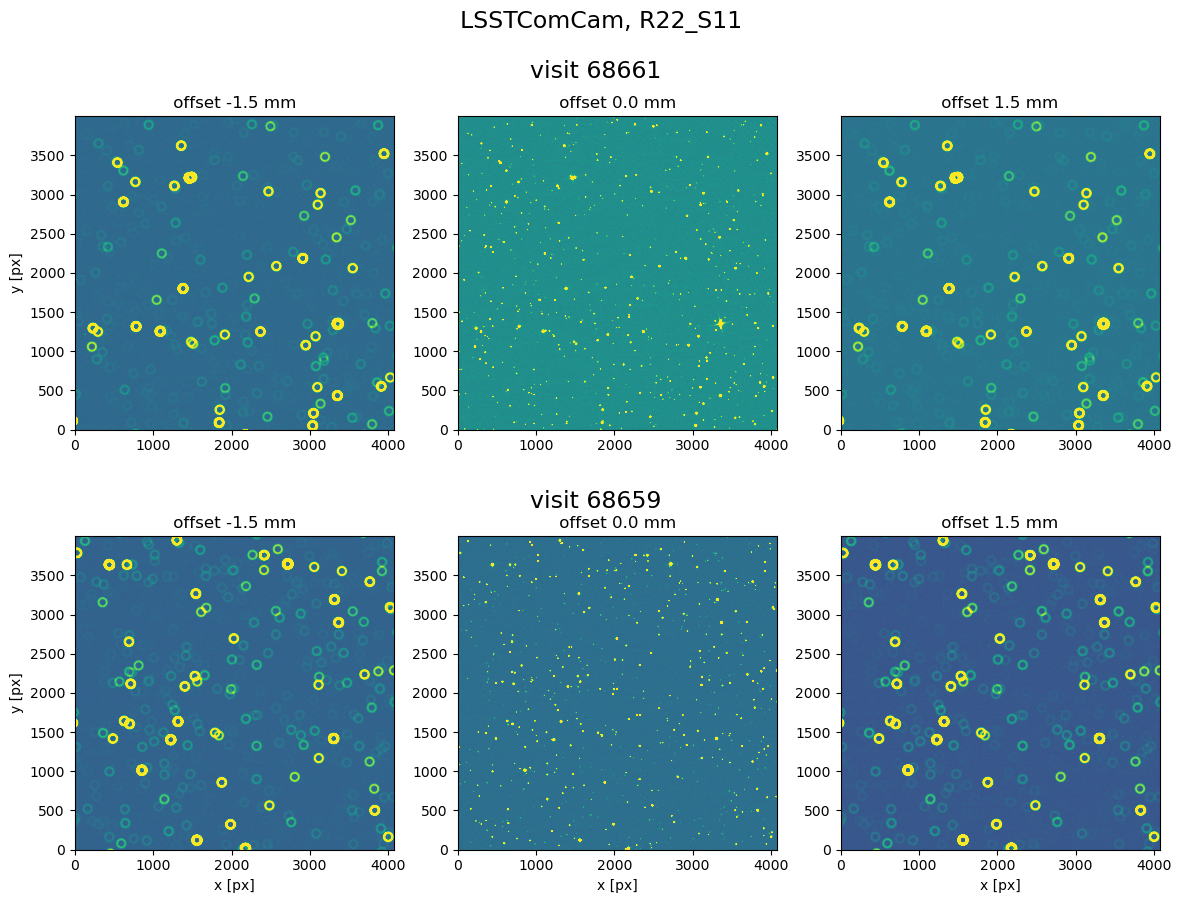

In [60]:

import matplotlib.pyplot as plt
from astropy.visualization import ZScaleInterval
fig,ax = plt.subplots(2,3, figsize=(14,10))

zscale = ZScaleInterval()

row=0
for seq_num, visit in zip(seq_nums, visits):
    col=0
    for i in range(3):
        exposure = exposures[seq_num]
        d = exposure.image.array
        focusz = exposure.visitInfo.focusZ
        vmin,vmax = zscale.get_limits(d)
        mappable = ax[row,col].imshow(d, vmin=vmin, vmax=vmax, origin='lower')
        ax[row,col].set_title(f' offset {focusz} mm ', )
        seq_num += 1 
        col += 1 
    row  += 1
    
suptitle =  f'{exposure.visitInfo.instrumentLabel}, {exposure.detector.getName()}'
fig.text(0.4,0.95,suptitle,fontsize=17)

suptitle2 = f'visit {visits[0]}'
fig.text(0.45,0.9,suptitle2,fontsize=17)

suptitle3 = f'visit {visits[1]}'
fig.text(0.45,0.47,suptitle3,fontsize=17)


row=1
for col in range(3):
    ax[row,col].set_xlabel('x [px]')
col=0
for row in range(2):
    ax[row,col].set_ylabel('y [px]')

fname = 'LsstComCam_R22_S11_visits_defocal.png'
fpath = os.path.join(path_cwd, fname)
print(f'Saved as {fpath}')
plt.savefig(fpath, bbox_inches='tight')

# Run WEP on the postISR defocal images:

In [8]:
from lsst.ts.wep.utils import getConfigDir as getWepConfigDir
def writeWepConfigurationWepOnly(instName, pipelineYamlPath,butlerInstName):
        """Write wavefront estimation pipeline task configuration.

        Parameters
        ----------
        instName : str
            Name of the instrument this configuration is intended for.
        pipelineYamlPath : str
            Path where the pipeline task configuration yaml file
            should be saved.
        filterTypeName : str
            Filter type name: ref (or ''), u, g, r, i, z, or y.
        """

        

        with open(pipelineYamlPath, "w") as fp:
            fp.write(
                f"""# This yaml file is used to define the tasks and configuration of
# a Gen 3 pipeline used for testing
description: basic processing pipeline with imsim
# Here we specify the corresponding instrument for the data we
# will be using.
instrument: lsst.obs.lsst.Lsst{butlerInstName}
# Use imported instrument configuration
imports:
  - location: {getWepConfigDir()}/cwfs/instData/{instName}/instParamPipeConfig.yaml
# Then we can specify each task in our pipeline by a name
# and then specify the class name corresponding to that task
tasks:
  generateDonutCatalogWcsTask:
    class: lsst.ts.wep.task.generateDonutCatalogWcsTask.GenerateDonutCatalogWcsTask
    config:
    # this config points to the GAIA DR2 refcat
      connections.refCatalogs: gaia_dr2_20200414
      anyFilterMapsToThis: phot_g_mean
      donutSelector.useCustomMagLimit: True
      donutSelector.magMax: 15.0
      donutSelector.magMin: 8.0
      donutSelector.unblendedSeparation: 160
    """)
    
    
instName = 'comcam'
path_cwd = '/sdf/data/rubin/shared/scichris/DM-41679_lsstComCam/'
pipelineYamlPath = os.path.join(path_cwd, "lsstPipelineWEP.yaml")
butlerInstName='ComCam'
writeWepConfigurationWepOnly(instName, pipelineYamlPath,butlerInstName)   



In [7]:
from lsst.ts.wep.utils import  runProgram
runName = 'run1'
numPro=5
butlerRootPath = os.path.join(path_cwd, 'gen3repo_1e9')

cmd = f"pipetask run -b {butlerRootPath} "+\
            f"-i refcats/gaia_dr2_20200414,{runName},LSST{butlerInstName}/calib/unbounded "+\
            f"--instrument lsst.obs.lsst.Lsst{butlerInstName} "+\
            f"--register-dataset-types --output-run {runName}   -p {pipelineYamlPath} -d "+\
           f'"exposure.seq_num in (940,942)" -j {numPro}'
print('Running', cmd)
runProgram(cmd)

Running pipetask run -b /sdf/data/rubin/shared/scichris/DM-41679_lsstComCam/gen3repo_1e9 -i refcats/gaia_dr2_20200414,run1,LSSTComCam/calib/unbounded --instrument lsst.obs.lsst.LsstComCam --register-dataset-types --output-run run1   -p /sdf/data/rubin/shared/scichris/DM-41679_lsstComCam/lsstPipelineWEP.yaml -d "exposure.seq_num in (940,942) " -j 5


This looks good - just needed to point WEP which seqNums to use. Of all detectors it selects pairs, and picks which is extra/intra based on focusZ. 

In [1]:
from lsst.daf import butler as dafButler
path_cwd = '/sdf/data/rubin/shared/scichris/DM-41679_lsstComCam/'
butlerRootPath = os.path.join(path_cwd, 'gen3repo_1e9')
butler = dafButler.Butler(butlerRootPath)
registry = butler.registry
collectionsList = list(registry.queryCollections())
print(collectionsList)

registry = butler.registry
datasetTypes = list(registry.queryDatasetTypes())
for dt in datasetTypes:
    print(dt)
    

['LSSTComCam/calib', 'LSSTComCam/calib/unbounded', 'LSSTComCam/raw/all', 'run1', 'refcats/gaia_dr2_20200414', 'refcats']
DatasetType('camera', {instrument}, Camera, isCalibration=True)
DatasetType('raw', {band, instrument, detector, physical_filter, exposure}, Exposure)
DatasetType('packages', {}, Packages)
DatasetType('isr_config', {}, Config)
DatasetType('postISRCCD', {band, instrument, detector, physical_filter, exposure}, Exposure)
DatasetType('isr_metadata', {band, instrument, detector, physical_filter, exposure}, TaskMetadata)
DatasetType('isr_log', {band, instrument, detector, physical_filter, exposure}, ButlerLogRecords)
DatasetType('gaia_dr2_20200414', {htm7}, SimpleCatalog)
DatasetType('cutOutDonutsScienceSensorTask_config', {}, Config)
DatasetType('calcZernikesTask_config', {}, Config)
DatasetType('generateDonutCatalogWcsTask_config', {}, Config)
DatasetType('donutCatalog', {band, instrument, detector, physical_filter, visit}, DataFrame)
DatasetType('donutStampsExtra', {band

In [12]:
datasetRefs = butler.registry.queryDatasets(datasetType='zernikeEstimateRaw',
                                            collections=['run1']).expanded()
for ref  in datasetRefs:
    print(ref)
    

zernikeEstimateRaw@{instrument: 'LSSTComCam', detector: 1, visit: 5025082000942, band: 'g', physical_filter: 'g_01'} [sc=NumpyArray] (run=run1 id=5250cc70-5951-48c8-afcc-431fb8eacbe8)
zernikeEstimateRaw@{instrument: 'LSSTComCam', detector: 7, visit: 5025082000942, band: 'g', physical_filter: 'g_01'} [sc=NumpyArray] (run=run1 id=a8ea17a7-9658-4667-b008-64e6ae0f1ac4)
zernikeEstimateRaw@{instrument: 'LSSTComCam', detector: 4, visit: 5025082000942, band: 'g', physical_filter: 'g_01'} [sc=NumpyArray] (run=run1 id=be902b73-8711-44fc-bf68-9a3a707f00e9)
zernikeEstimateRaw@{instrument: 'LSSTComCam', detector: 5, visit: 5025082000942, band: 'g', physical_filter: 'g_01'} [sc=NumpyArray] (run=run1 id=25cdbf0f-1851-4581-b6c5-b85da4cd6b35)
zernikeEstimateRaw@{instrument: 'LSSTComCam', detector: 8, visit: 5025082000942, band: 'g', physical_filter: 'g_01'} [sc=NumpyArray] (run=run1 id=3257e6ed-9ed8-4d9c-8c3b-9a3f5c3c6b8b)
zernikeEstimateRaw@{instrument: 'LSSTComCam', detector: 6, visit: 5025082000942,

So `zernikeEstimateRaw` is stored with the extra-focal `seqNum`. 

Load an exposure and associated donut stamps and Zernike estimate: 

In [62]:
from lsst.daf import butler as dafButler

collection = 'run1'
instrument= 'LSSTComCam'
detector=1
exposure_number = 5025082000942

# construct a dataId  for postISR extra-focal 
data_id_extra = {
    "detector": detector,
    "instrument": instrument,
    "exposure": exposure_number,
}
data_id_intra = { "detector": detector, "instrument": instrument, "exposure": exposure_number-1}
# read the postISR exposure
exposure_extra = butler.get("postISRCCD", data_id_extra, collections=[collection])


exposure_intra = butler.get("postISRCCD", data_id_intra, collections=[collection])

In [63]:

# construct a dataId for zernikes and donut catalog:
# switch exposure to visit
data_id_extra = {"detector": detector, 
           "instrument": instrument, 
           "visit": exposure_number
          }

# the raw Zernikes are all stored for the extra-focal visit ,,., 
zernikes_raw = butler.get(
    "zernikeEstimateRaw", dataId=data_id_extra, collections=[collection]
)

zernikes_avg = butler.get(
    "zernikeEstimateAvg", dataId=data_id_extra, collections=[collection]
)

donut_stamps = butler.get(
    "donutStampsExtra", dataId=data_id_extra, collections=[collection]
)



In [64]:
donut_catalog = butler.get(
    "donutCatalog",  dataId=data_id_extra, collections=[collection]
    )


In [65]:
donut_catalog

,coord_ra,coord_dec,centroid_x,centroid_y,source_flux,blend_centroid_x,blend_centroid_y
0,5.135936,-1.424587,752.157910,1634.284667,4.183547e+08,[],[]
1,5.117717,-1.425254,3480.026370,933.924587,4.209907e+07,[],[]
2,5.128597,-1.425310,1852.465748,889.082502,1.981823e+07,[],[]
3,5.128355,-1.423396,1895.412900,2863.578870,1.367908e+07,[],[]
4,5.135854,-1.425172,766.916365,1031.037117,1.128154e+07,[],[]
5,5.131918,-1.422560,1355.598245,3726.501009,1.020909e+07,[],[]
6,5.118401,-1.424764,3384.355529,1439.640728,9.606770e+06,[],[]
7,5.115039,-1.424276,3897.215382,1935.582721,8.544578e+06,[],[]
8,5.116164,-1.425167,3713.708846,1019.639353,6.711749e+06,[],[]
9,5.136862,-1.423063,605.180471,3206.126424,5.591078e+06,[],[]


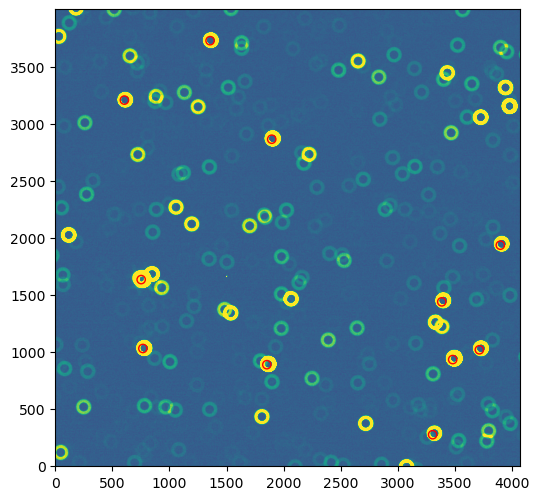

In [66]:
import matplotlib.pyplot as plt
from astropy.visualization import ZScaleInterval
fig,ax = plt.subplots(1,1, figsize=(6,6))

zscale = ZScaleInterval()

d = exposure_extra.image.array
vmin,vmax = zscale.get_limits(d)
plt.imshow(d,origin='lower', vmin=vmin, vmax=vmax)
#m = donut_catalog['phot_g_mean_mag'].values.value < 13.0
plt.scatter(donut_catalog['centroid_x'], donut_catalog['centroid_y'],
            facecolors='none', edgecolors='r')

The chosen donut locations look to align well with source locations ... Look at the postage stamps: 

In [23]:
len(donut_stamps)

11

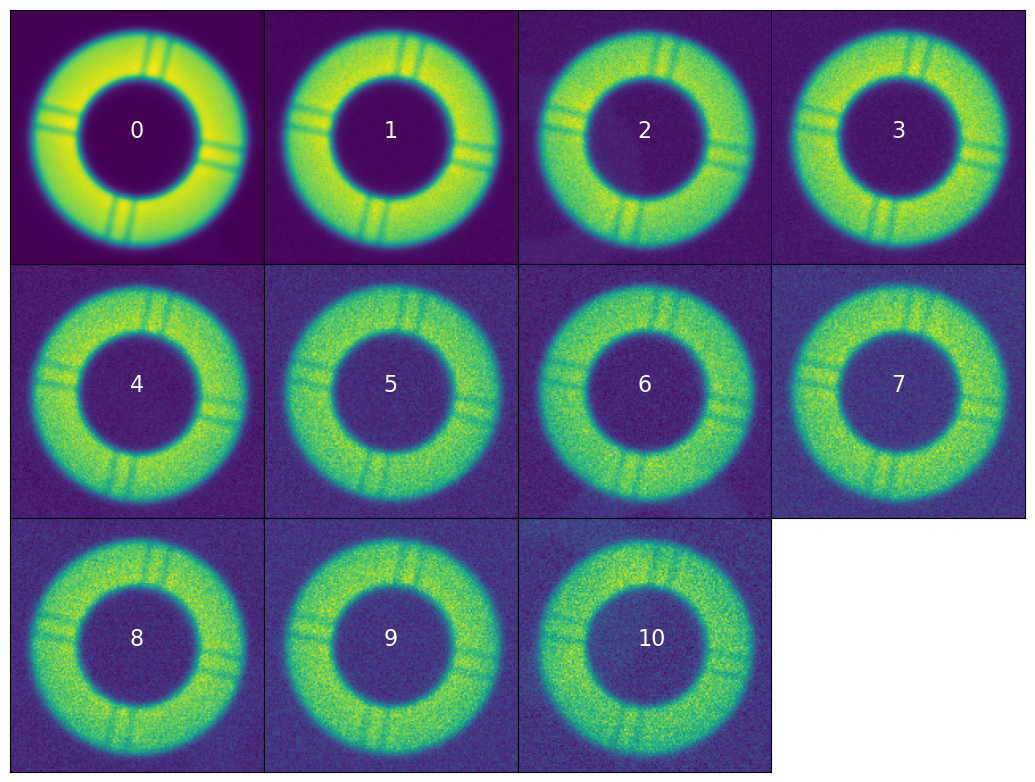

In [12]:
%matplotlib inline
import numpy as np
fig,axs = plt.subplots(3,4, figsize=(13.1,9.9))
ax = np.ravel(axs)
for i in range(len(donut_stamps)):
    stamp = donut_stamps[i]
    ax[i].imshow(stamp.stamp_im.image.array)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].text(75
            ,80,i, fontsize=16, color='white')
ax[-1].set_axis_off()
fig.subplots_adjust(hspace=0, wspace=0)


Plot the resulting zernike estimate, as well as the average : 

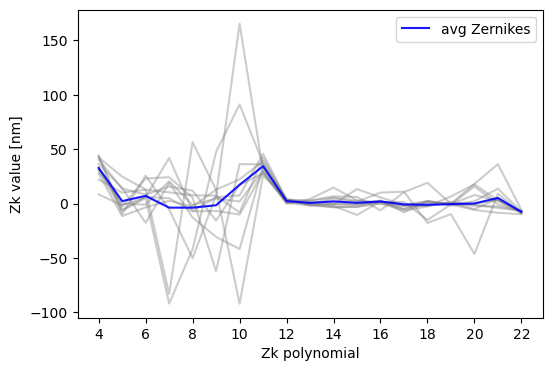

In [70]:
fig,ax = plt.subplots(1,1,figsize=(6,4))
#zkOpd = opdPerDet[detector]
#ax.plot(range(4,23), zkOpd[3:22], c='red', label='header-based OPD')
for i in range(len(zernikes_raw)):
    ax.plot(range(4,23), zernikes_raw[i]*1000, alpha=0.4, c='grey'
            )
ax.plot(range(4,23), zernikes_avg*1000, alpha=0.9, c='blue', label='avg Zernikes'
            )
ax.legend()
ax.set_ylabel('Zk value [nm]')
ax.set_xlabel('Zk polynomial')
ax.set_xticks([4,6,8,10,12,14,16,18,20,22])
